In [186]:
import pandas as pd
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import signal

In [225]:
df = pd.read_csv('LE_cleaned_data.csv')
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.sample(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1190,India,2011-01-01,Developing,66.8,193.0,1100,3.000000,64.605901,44.000000,33634,...,79.000000,4.33000,82.000000,0.2,1461.671957,124723629.0,26.900000,27.700000,0.580,10.8
486,Cameroon,2009-01-01,Developing,54.8,373.0,54,5.890000,9.042541,8.000000,251,...,79.000000,5.70000,8.000000,6.3,123.195380,19432541.0,6.300000,6.300000,0.473,9.2
1697,Mexico,2001-01-01,Developing,75.0,126.0,52,4.860000,13.311095,97.000000,3,...,97.000000,5.35000,97.000000,0.1,731.378864,136768.0,1.900000,1.900000,0.700,11.6
2424,South Sudan,2000-01-01,Developing,48.9,38.0,31,4.602861,0.000000,80.940461,0,...,82.550188,5.93819,82.324084,2.7,7483.158469,67656.0,4.839704,4.870317,0.000,0.0
568,China,2007-01-01,Developing,74.4,96.0,285,3.880000,312.662482,92.000000,109023,...,94.000000,4.32000,93.000000,0.1,2695.366223,1317885.0,4.700000,4.100000,0.659,11.4
1480,Lesotho,2009-01-01,Developing,49.4,566.0,4,2.750000,104.314473,91.000000,0,...,89.000000,9.80000,91.000000,18.2,923.136931,21929.0,7.600000,7.400000,0.453,10.8
2039,Poland,2015-01-01,Developed,77.5,117.0,2,4.602861,0.000000,96.000000,0,...,92.000000,5.93819,98.000000,0.1,12565.987600,37986412.0,1.900000,2.000000,0.852,16.4
1878,Niger,2014-01-01,Developing,61.4,223.0,49,0.010000,3.304040,68.000000,1142,...,67.000000,5.82000,68.000000,0.5,43.646498,19148219.0,9.800000,9.600000,0.345,5.3
846,Equatorial Guinea,2003-01-01,Developing,53.8,334.0,3,7.130000,309.783459,80.940461,18,...,46.000000,2.23000,37.000000,3.6,3577.176197,694611.0,1.200000,1.100000,0.554,8.4
2734,Ukraine,2011-01-01,Developing,75.0,24.0,5,8.480000,415.162771,21.000000,1333,...,54.000000,6.98000,5.000000,0.2,3569.757270,45761.0,2.400000,2.500000,0.734,14.9


# Analysis

## Tuổi thọ có tính ổn định thống kê (H1) hay không (Stationarity)?

<AxesSubplot:xlabel='Year'>

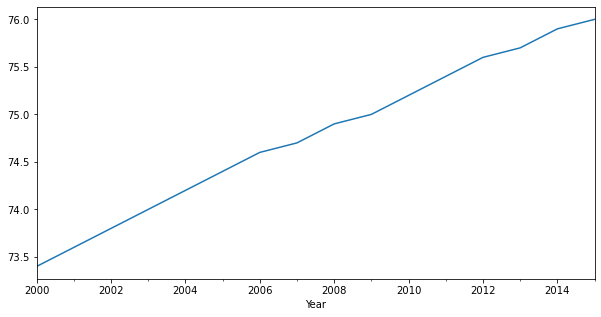

In [226]:
df.loc[df.Country == 'Viet Nam']
time = df.pivot(index='Year', columns='Country', values='Life expectancy')
vn = time['Viet Nam']
vn.plot(kind='line', figsize=(10, 5))

In [227]:
test = vn.reset_index()
df_station = adfuller(test['Viet Nam'], autolag='AIC')
print('P-value: ', df_station[1])

P-value:  0.5180114060633305


Với giá trị p-value > 0.05, ta bác bỏ H1, nên dữ liệu không có tính ổn định thống kê theo thời gian.

In [228]:
time = time.T

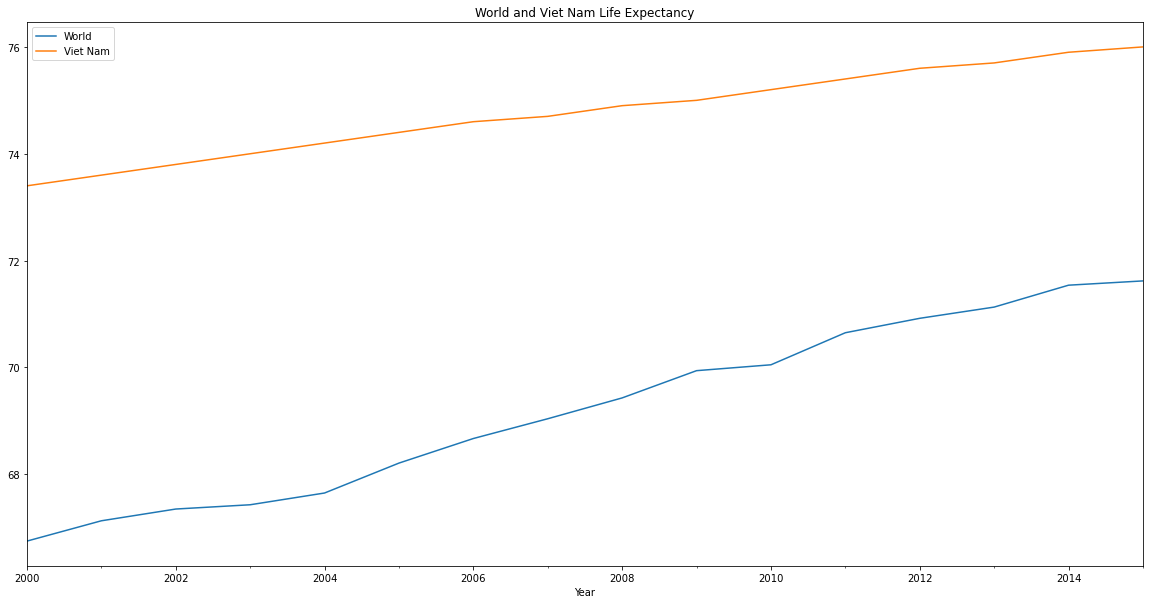

In [229]:
world = time.describe().round(2)
world = world.loc[world.index == 'mean']
world = world.T.rename({'mean': 'World'}, axis=1)
merged = world.reset_index().merge(vn.reset_index(),left_on = 'Year', right_on = 'Year', how = 'inner')
merged.set_index('Year', inplace=True)
merged.plot(kind='line', figsize=(20, 10), title='World and Viet Nam Life Expectancy');

Kết luận:
- Dữ liệu có xu thế tăng theo thời gian.
- Dữ liệu không có tính ổn định thống kê theo thời gian.

## Phân tích yếu tố chu kỳ (Cycling)

Tuổi thọ có yếu tố chu kỳ không?

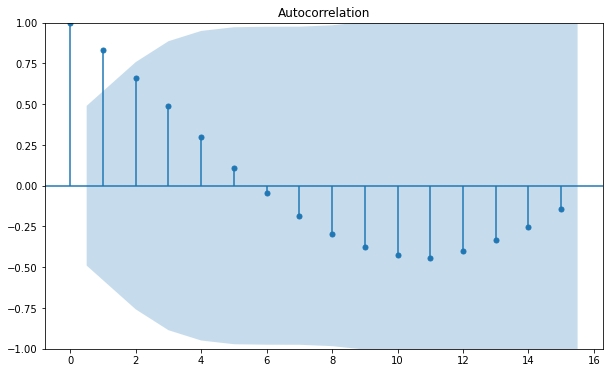

In [218]:
acf_cal = world.reset_index().rename(columns={'World':'Life Expectancy'})
mpl.rc("figure", figsize=(10, 6))
plot_acf(acf_cal["Life Expectancy"], lags = 15);

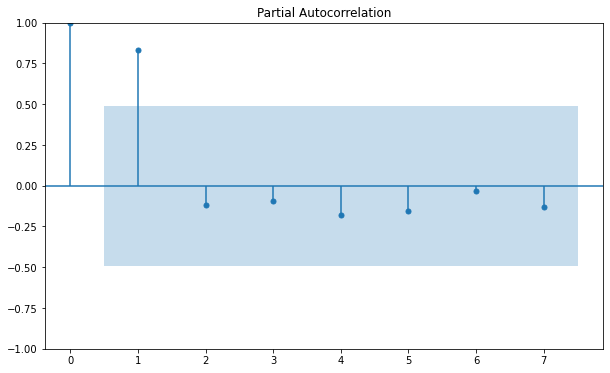

In [219]:
plot_pacf(acf_cal["Life Expectancy"], lags = 7, method='ywm');

Kiểm định Durbin-Watson cho sự tự tương quan.

In [230]:
gfg = durbin_watson(acf_cal["Life Expectancy"])
gfg

2.5885519199508616e-05

Kết luận: 
- tuổi thọ không có yếu tố chu kỳ hay mùa vụ(ít nhất trên tập dữ liệu này).
- Tuổi thọ có sự tự tương quan dương.

## Loại bỏ xu thế (Detrend)

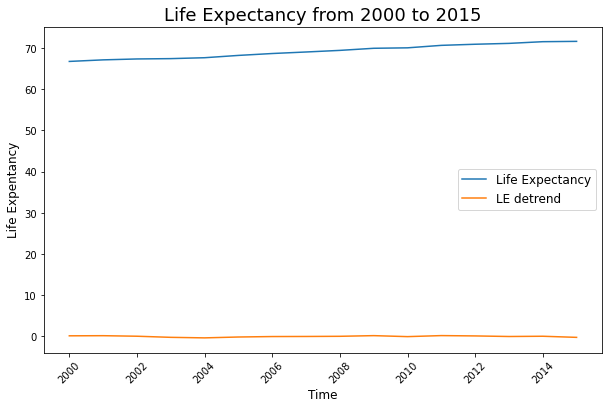

In [231]:
temp = world.reset_index().rename(columns={'World':'Life Expectancy'})

detr = signal.detrend(temp['Life Expectancy'])
detr = pd.DataFrame({'LE detrend':detr},index = world.index)

temp.set_index('Year', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(temp["Life Expectancy"], label=temp.columns[0])
plt.plot(detr, label=detr.columns[0])
plt.xticks(rotation=45)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Life Expentancy", fontsize=12)
plt.legend(fontsize=12)
plt.title("Life Expectancy from 2000 to 2015", fontsize=18)
plt.show()

## Phân rã mùa vụ (Decompose)

Vì không có yếu tố mùa vụ nên kh biết nên đưa vô kh nữa :v

In [196]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# temp = temp.reset_index()
# temp['Year'] = pd.to_datetime(temp['Year'], format='%Y')
# temp = temp.set_index('Year')
# temp
# result = seasonal_decompose(temp['Life Expectancy'], model='additive')
# result.plot()
# plt.show()

# Autoregression Model (AR)

Thực hiện mô hình, dựa trên yếu tố xu thế, nhóm em nhận thấy có thể triển khai thử mô hình AR(1) để dự đoán tuổi thọ. Về mặt ý nghĩa, mô hình AR(1) tương tự như mô hình hồi quy tuyến tính. Tuy nhiên, mô hình AR(1) có thêm yếu tố tự tương quan giữa các giá trị quan sát liền trước và liền sau để có thể dự đoán cho năm tiếp theo.

\begin{equation}
x_t = \theta_0 + \theta_1 x_{t-1} + \theta_2 x_{t-2}+ ... + \epsilon_t
\end{equation}

với t là thời gian, $\theta$ là hệ số hồi quy, $\epsilon$ là nhiễu.

In [232]:
world

,World
Year,
2000-01-01,66.75
2001-01-01,67.13
2002-01-01,67.35
2003-01-01,67.43
2004-01-01,67.65
2005-01-01,68.21
2006-01-01,68.67
2007-01-01,69.04
2008-01-01,69.43


In [233]:
world.index = pd.DatetimeIndex(world.index.values, freq=world.index.inferred_freq)
train, test = train_test_split(world, test_size=0.2, shuffle=False)

ar_model = AutoReg(train, lags=1).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  World   No. Observations:                   12
Model:                     AutoReg(1)   Log Likelihood                   4.471
Method:               Conditional MLE   S.D. of innovations              0.161
Date:                Wed, 17 May 2023   AIC                             -2.941
Time:                        17:04:43   BIC                             -1.747
Sample:                    01-01-2001   HQIC                            -3.693
                         - 01-01-2011                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6123      2.991     -0.874      0.382      -8.474       3.249
World.L1       1.0434      0.044     23.844      0.000       0.958       1.129
                                    Roots           

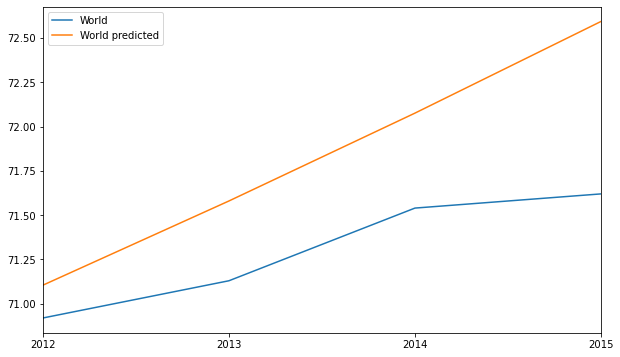

In [235]:
pred = ar_model.predict(start = len(train), end = (len(world)-1));
pred = pd.DataFrame({'World predicted': pred.values}, index = test.index)

# merge_pred = pd.concat([train, pred], axis=0).rename(columns={'World':'World predicted'})
comp = pd.concat([test, pred], axis=1)
comp.plot(kind='line');

Độ lỗi của AR(1) trên tập test

In [237]:
print('MSE: ', mean_squared_error(test, pred))

MSE:  0.36758960734159785


Dựa trên kết quả MSE, ta có thể sử dụng AR(1) model để dự đoán tuổi thọ.

## Dự đoán kết quả trên thế giới vào năm 2016 và 2017

In [238]:
ar_model = AutoReg(world, lags=1).fit()

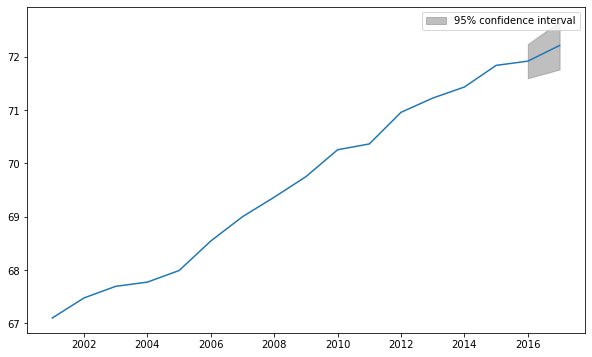

In [239]:
pred = ar_model.predict(start = len(world), end = (len(world)+1));
ar_model.plot_predict(start = 1, end = (len(world)+1), dynamic=False);

In [240]:
pred

2016-01-01    71.917447
2017-01-01    72.211733
Freq: AS-JAN, dtype: float64

Kết quả dự đoán trung bình tuổi thọ trên toàn thế giới vào năm 2016 là 71.91 tuổi, vào năm 2017 là 72.21 tuổi. Với độ trễ là 1.

## Dự đoán tuổi cho Việt Nam vào năm 2016 và 2017

In [244]:
vn.index = pd.DatetimeIndex(vn.index.values, freq=vn.index.inferred_freq)

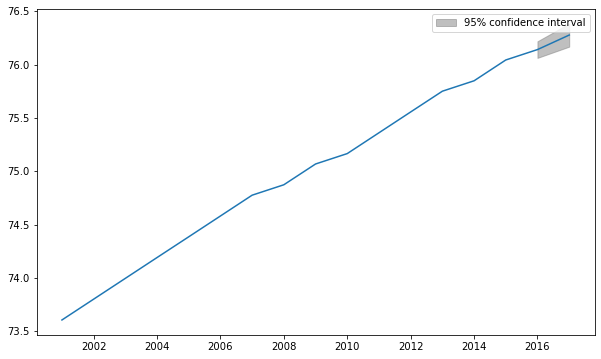

In [245]:
ar_model = AutoReg(vn, lags=1).fit()
pred_vn = ar_model.predict(start = len(vn), end = (len(vn)+1));
ar_model.plot_predict(start = 1, end = (len(vn)+1), dynamic=False);

In [246]:
pred_vn

2016-01-01    76.139772
2017-01-01    76.275955
Freq: AS-JAN, dtype: float64

Dự đoán tuổi thọ cho Việt Nam năm 2016 là 76.14 tuổi và 2017 là 76.28 tuổi.

Nhận xét: Có thể thấy tuổi thọ Việt Nam cao hơn so với tuổi thọ trung bình trên toàn thế giới.